### Initial Classifier 2022-03
This file processes data, creates features, trains and finally tests our initial model for classifying road LTS in Toronto.
All functions are stored in a seperate python file within the folder

In [1]:
#Import all packages from model functions
from model_functions import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('dark_background')

Import the data, Test-Train Split

In [51]:
train_data = pd.read_csv('C:/Users/Keagan Rankin/Documents/PycharmProj/data/training_data/ysign_dropoff2_iter15_train.csv')
train_data.head()

,Unnamed: 0,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,Shape_Leng,geometry,ysign vehicle,ysign ped,high access
0,26720,26722,1137670,3025,Bocastle Ave,13453368,13453237,0,95.530596,1137670,1,0.000883,LINESTRING (628767.3368918777 4843212.59019024...,4790.250,973.25,1
1,45540,45542,111369,8220,Kenmark Blvd,13453101,13453173,0,228.998686,111369,1,0.002671,LINESTRING (639762.0980769163 4843420.41458969...,2446.250,329.25,1
2,14362,14363,14048139,3053,Brandon Ave,13463765,14048141,0,49.852955,14048139,1,0.000607,LINESTRING (625363.2529044797 4836317.83499265...,1582.625,73.25,1
3,36418,36420,2689046,3803,Lake Shore Blvd E,13466078,13466003,0,105.443542,2689046,4,0.001222,LINESTRING (633798.3739368191 4834729.22944054...,1327.250,7.00,0
4,15812,15813,14040464,11872,Ln 1 W Clinton N Gore,14040383,14040467,0,22.935001,14040464,1,0.000214,LINESTRING (627870.1851326771 4834730.84276338...,906.375,451.50,1


### Clean data and create features using the functions in the import file

In [52]:
# Split features and target
y_train_lts = train_data['LTS']
y_train_access = train_data['high access']
X_train = train_data.drop(['LTS','high access'], axis=1)

In [53]:
# Run the feature creation functions from imports
keep_rows = ['OBJECTID',	'GEO_ID',	'ONE_WAY_DI', 'geometry', 'ysign vehicle', 'ysign ped']
X_train = ysign_droprows(X_train, keep_rows)
X_train = ysign_scale(X_train, ['ysign vehicle', 'ysign ped'])
X_train.head()

,OBJECTID,GEO_ID,ONE_WAY_DI,geometry,ysign vehicle,ysign ped
0,26722,1137670,0,LINESTRING (628767.3368918777 4843212.59019024...,0.094336,0.258095
1,45542,111369,0,LINESTRING (639762.0980769163 4843420.41458969...,-0.330468,-0.118231
2,14363,14048139,0,LINESTRING (625363.2529044797 4836317.83499265...,-0.486982,-0.267827
3,36420,2689046,0,LINESTRING (633798.3739368191 4834729.22944054...,-0.533264,-0.306540
4,15813,14040464,0,LINESTRING (627870.1851326771 4834730.84276338...,-0.609539,-0.046794


Define the models - choose betwene different classification models

In [54]:
model_log = LogisticRegression()
model_svm = svm.SVC()
model_rf = RandomForestClassifier()

Select Features: use selectKbest or a built in selector in regularization or random forest

Fit a basic model

Advanced Cross Validation: use a function that bins by area?

Tune Hyper Parameters

In [69]:
cv = StratifiedKFold(n_splits=10)

# Choose hyper-params
params_log = {'penalty': ('l1', 'l2'),
              'fit_intercept': (True, False),
              'C': loguniform(1e-3, 1e2),
              'class_weight': (None, 'balanced')
             }

# Do the search (might take awhile)
r_search_log = RandomizedSearchCV(estimator=model_log,
                                  param_distributions=params_log,
                                  n_iter=200,
                                  scoring='f1_weighted',
                                  cv=cv,
                                 )

r_search_log.fit(X_train[['ysign vehicle']], y_train_lts)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=LogisticRegression(), n_iter=200,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024A34C959D0>,
                                        'class_weight': (None, 'balanced'),
                                        'fit_intercept': (True, False),
                                        'penalty': ('l1', 'l2')},
                   scoring='f1_weighted')

In [71]:
print('best weighted score', r_search_log.best_score_)
print('best estimator: ',r_search_log.best_estimator_)

best weighted score 0.46050643994455187
best estimator:  LogisticRegression(C=0.1628828044322085, class_weight='balanced')


In [72]:
model_baseline = LogisticRegression(C=0.16, class_weight='balanced')
model_baseline.fit(X_train[['ysign vehicle']], y_train_lts)

y_pred = model_baseline.predict(X_train[['ysign vehicle']])

### Evaluate the Baseline model

Visualize the decision boundary:

In [73]:
print('accuracy: ', accuracy_score(y_train_lts, y_pred))
print('weighted f1: ', f1_score(y_train_lts, y_pred, average='weighted'))

accuracy:  0.4827287516109268
weighted f1:  0.46097717318680265


ValueError: X has 2 features, but LogisticRegression is expecting 1 features as input.

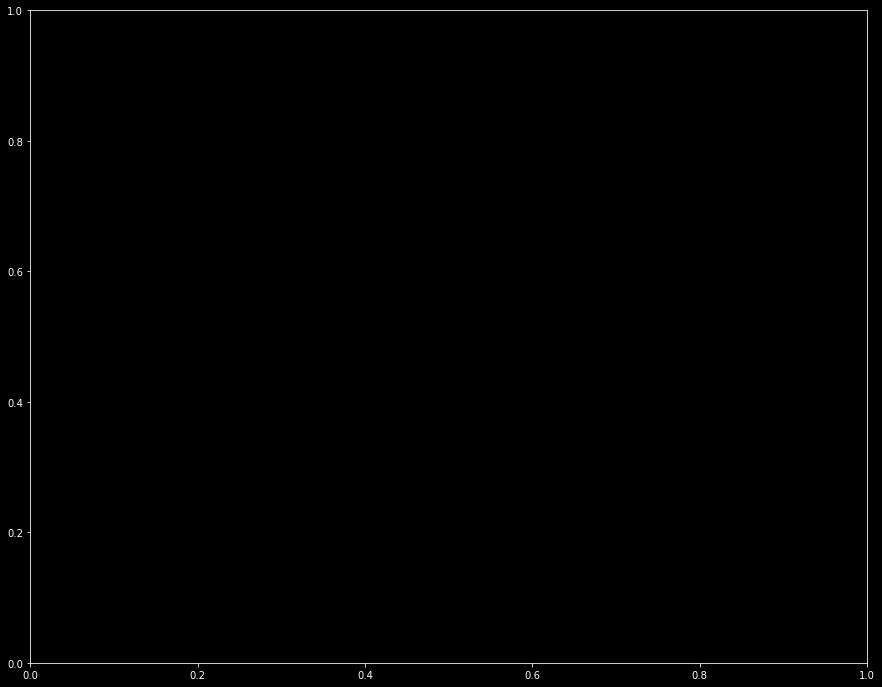

In [57]:
# Create np meshgrid.
xx, yy = np.mgrid[-2:10:.01, -1:30:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
#probs = model_baseline.predict_proba(grid)[:, 1].reshape(xx.shape)

# Plot results
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Figure
f, ax = plt.subplots(figsize=(15, 12))
plot_contours(ax, model_baseline, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
#ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)

#Plot
ax.scatter(X_train['ysign vehicle'], X_train['ysign ped'], c=y_train_access, s=50,
           cmap="coolwarm", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1, label='high access')

# Parameters
ax.grid(False)
ax.set_ylabel('Scaled Ped YSIGN')
ax.set_xlabel('Scaled Vehicle YSIGN')
ax.legend()

plt.show()

Plot the confusion matrix, threshold, and roc curve.

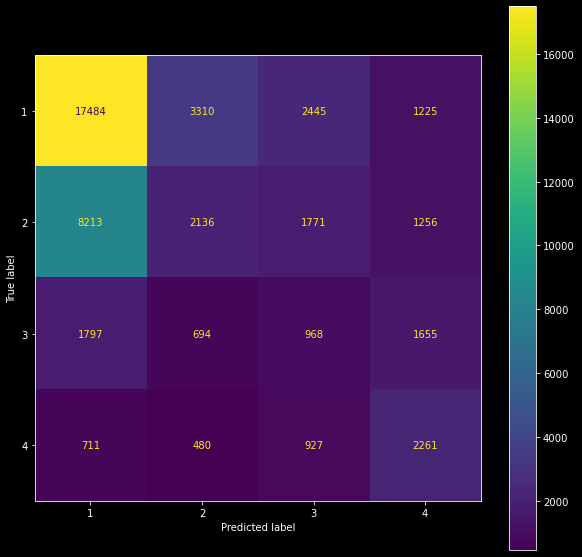

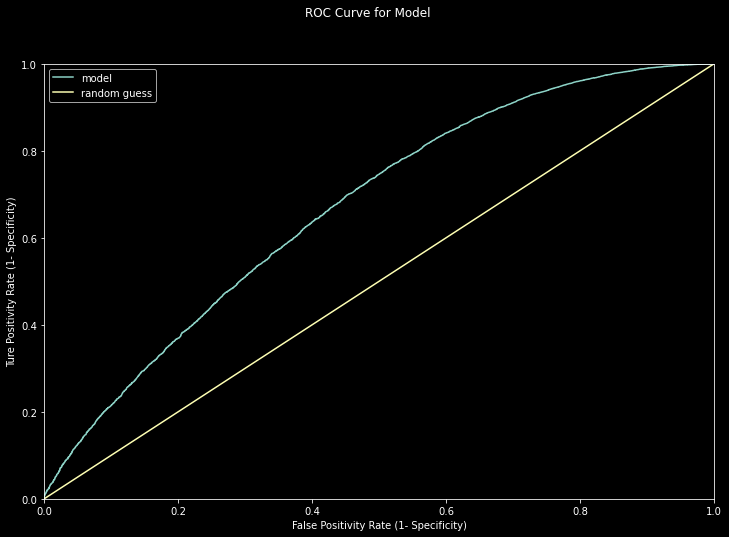

In [74]:
# Confusion matrix
f, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model_baseline, X_train[['ysign vehicle']], y_train_lts, ax=ax)
ax.grid(False)

#Weighted F1 score with optimal threshold if relevant
#plot_f1_threshold(X_train[['ysign vehicle']], y_train_lts, model_baseline)

#roc curve
plot_roc(y_train_lts, model_baseline.predict_proba(X_train[['ysign vehicle']]))

Plot the correctly and incorrectly classified data

In [75]:
predicted = pd.Series(y_pred)
predicted = pd.concat((train_data, predicted), axis=1)

In [76]:
lts_gpd = gpd.read_file('C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Bo Github Data/centerline_LTS_July2021.shp')
lts_gpd = lts_gpd[lts_gpd['LTS'] != 0]
lts_gpd['high access'] = lts_gpd['LTS'].apply(lambda x: 1 if x <= 2 else 0)

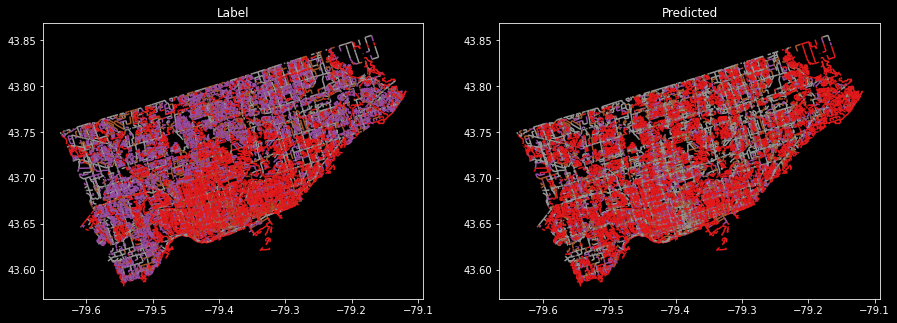

In [78]:
# Plot the above to show the new data. Show with 4 LTS and with the high/low access grouping
# Geoframe
plotr = pd.merge(lts_gpd,
                 predicted[['GEO_ID',0]],
                 how='left',
                 left_on='GEO_ID',
                 right_on='GEO_ID',)

plotr = plotr.dropna()

# Figure
fig, axs = plt.subplots(figsize=(15,12), ncols=2)

# Plotting
plotr.plot(ax=axs[0], column='LTS', cmap='Set1')
plotr.plot(ax=axs[1], column=0, cmap='Set1')

# Attributes
axs[0].title.set_text('Label')
axs[1].title.set_text('Predicted')
axs[0].grid(False)
axs[1].grid(False)

plt.show()

Notes:
The baseline model with one feature has an okay weighted f1 for the binary classification (0.82), but it is really quite bad at predicting roads with low accessibility; it mislabels most of these (6689 vs 2804 correct) at a dropoff coefficient of 2. A higher dropoff actually makes the model worse (meaning we are probably mis classifying even more low access high volume roads). Lowering the dropoff seems to perform even worse (8000 misclassified at dropoff of 1.25), probably because the data is coming closer together. It seems like ~2 is the best value for a dropoff with just the ysign data.